# Segment image series tutorial 

The goal of the *segment image series* function is to separate moderately overlapping plants in a set of multi-plant images taken over time (image time series). 

Users familiar with mutli-plant analysis workflows in PlantCV can use this function to extend the number of images where the data can be analyzed (the plants can be segmented appart).

Analyzing an image time series where plants overlap can be split into three main steps:

1. For each image generate a binary mask separating the plants from the background and save them in a directory.

2. Apply the steps in this tutorial to run *segment image series*. The output labels files assign individual labels for each plant.

3. Run a workflow that loads the labels and uses them to analyze each individual plant.

This tutorial assumes the binary masks were previously generated.

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
# Import libraries
import os
import numpy as np

from plantcv import plantcv as pcv 
from read_dataset import read_dataset


In [3]:
# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

# IMPORTANT: Create a directory to save the output labels and set the path in self.outdir

class options:
    def __init__(self):        
        self.image = ""
        self.debug = "plot"
        self.writeimg = False
        self.result = "segmentation"
        self.outdir = "./"

In [4]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# set the output directory to the global parameter
pcv.params.debug_outdir = args.outdir

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Create lists of paths to images and masks

In [5]:
# Paths to the directories containing the rgb images and the binary masks
images_directory = './img/'
masks_directory =  './mask/'

# Create the lists of paths to the images and masks
# The read_dataset function is included in this repository, infuture versions it will 
# be included in the PlantCV package
images_paths_sort = read_dataset(source_path=images_directory, sort=True)
masks_paths_sort = read_dataset(source_path=masks_directory, sort=True)

## Create regions of interest (ROI) in one of the images
The ROIs serve as markers for each individual plant. The pixels inside each ROI are labeled based only in the ROI in all time points. For this reason it is encouraged to use small ROIs. 

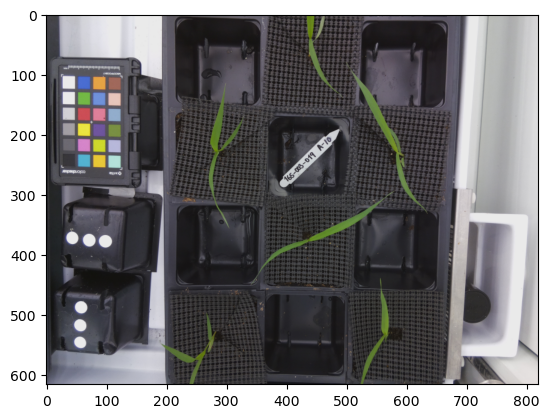

In [6]:
# Read the first image in the datased to be used as reference for the ROIs
i = 0
img0_path = images_paths_sort[i]
img0, _, _ = pcv.readimage(filename=img0_path)

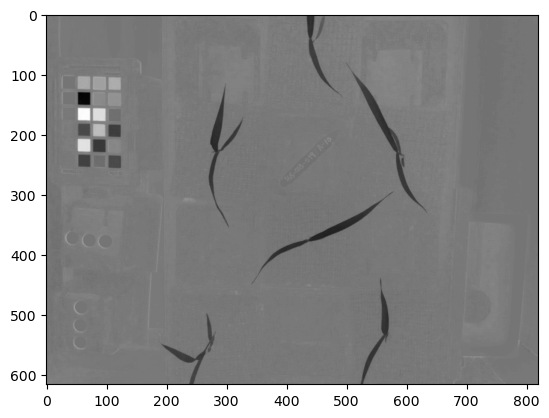

In [8]:
a = pcv.rgb2gray_lab(rgb_img=img0, channel='a')

In [9]:
hist = pcv.visualize.histogram(img=a, bins=25)

alt.Chart(...)

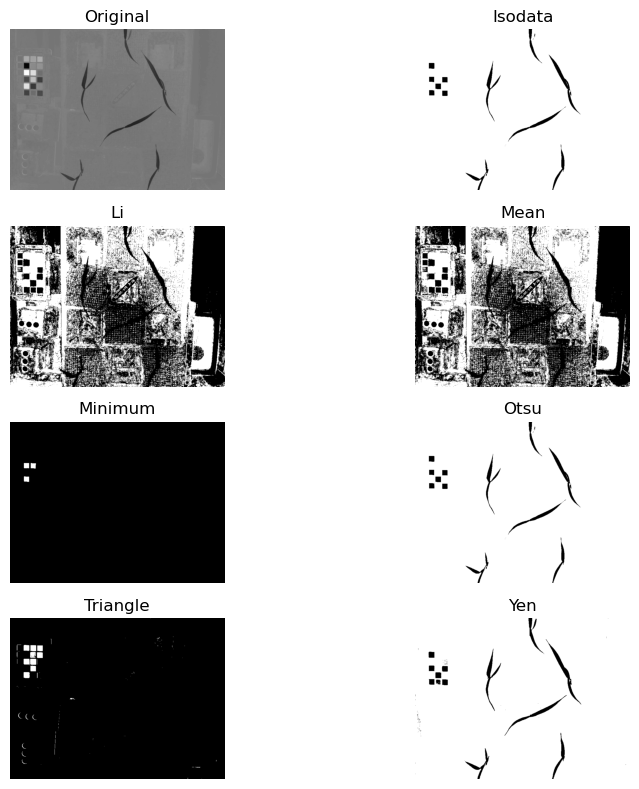

In [14]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(a, figsize=(10, 8), verbose=False)
#plt.show()

isodata, otsu and yen all seem like good filters for calculating a threshold value. However, it does seem like the colors are inverted, which could be a bit of a problem

In [7]:
# Create ROIs
rois = pcv.roi.auto_grid(mask=a_fill, nrows=4, ncols=3, img=img0)

NameError: name 'a_fill' is not defined

In [ ]:
# Discard the ROIs where there is no plant
valid_rois = [rois[i] for i in range(1,len(rois),2)]

In [ ]:
# Run segment image series 
out = pcv.segment_image_series(images_paths_sort, masks_paths_sort, rois=valid_rois , save_labels=True, ksize=3)